<a href="https://www.kaggle.com/code/ahmedrushdi/sarcasm?scriptVersionId=126912201" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# !pip install netron

In [2]:
import numpy as np 
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json
/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json


In [3]:
import pandas as pd
import re
from nltk.tokenize import word_tokenize


json_file_path1 = '/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json'
json_file_path2 = '/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json'


# Read the JSON files using pandas
data1 = pd.read_json(json_file_path1, lines=True)
data2 = pd.read_json(json_file_path2, lines=True)



# Combine the data into a single DataFrame
data = pd.concat([data1, data2])

data = data.drop('article_link', axis = 1).drop_duplicates()
data

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0
...,...,...
28497,tyson holds contest to let fans submit new ide...,1
28509,increasingly cocky bernie sanders announces he...,1
28520,cash-strapped zuckerberg forced to sell 11 mil...,1
28544,grocery store bar actually has great little ha...,1


In [4]:
data['word_count'] = data['headline'].apply(lambda s: len(word_tokenize(s)))
print(data.head())
data['word_count'].max()

                                            headline  is_sarcastic  word_count
0  former versace store clerk sues over secret 'b...             0          13
1  the 'roseanne' revival catches up to our thorn...             0          16
2  mom starting to fear son's web series closest ...             1          15
3  boehner just wants wife to listen, not come up...             1          14
4  j.k. rowling wishes snape happy birthday in th...             0          11


166

In [5]:
grouped_data = data.groupby('is_sarcastic')
grouped_data.count()

,headline,word_count
is_sarcastic,,
0,14951,14951
1,13552,13552


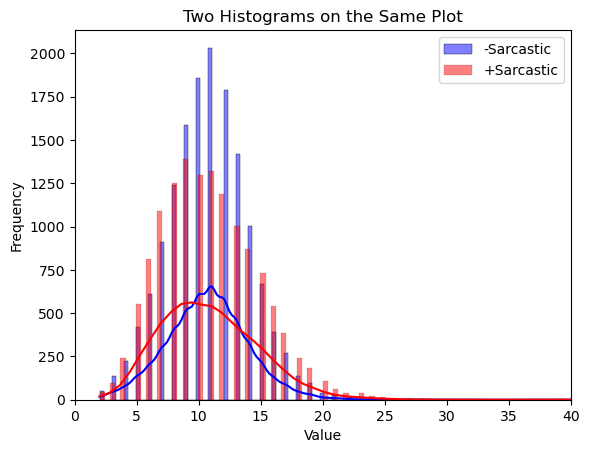

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the histograms
sns.histplot(data=data[data['is_sarcastic'] == 0]['word_count'], kde=True, color='blue', alpha=0.5, ax=ax, label='-Sarcastic')
sns.histplot(data=data[data['is_sarcastic'] == 1]['word_count'], kde=True, color='red', alpha=0.5, ax=ax, label='+Sarcastic')

# Customize the plot
ax.set_title('Two Histograms on the Same Plot')
ax.set_xlabel('Value')
ax.set_ylabel('Frequency')
ax.legend()
plt.xlim(0,40)
# Show the plot
plt.show()

In [7]:
corpus = data['headline']
labels = data['is_sarcastic']

In [8]:
import tensorflow as tf
import gensim.downloader as api
import numpy as np
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from keras.layers import Embedding, LSTM, Dense, GRU, Dropout, Bidirectional

In [9]:
w2v_model = api.load("word2vec-google-news-300")

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [10]:
vocab_size = len(w2v_model.key_to_index) +2  # Add 1 for the padding token
embedding_dim = w2v_model.vector_size

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, idx in w2v_model.key_to_index.items():
    embedding_matrix[idx+2] = w2v_model[word]

embedding_layer = Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    trainable=False,
)

In [11]:
len(list(w2v_model.key_to_index.keys()))

3000000

In [12]:
input_dim = vocab_size + 2  # Size of the vocabulary
input_length = 200  # Length of input sequences

text_vectorization = TextVectorization(
    max_tokens=input_dim,
    output_mode="int",
    output_sequence_length=input_length,
    vocabulary = list(w2v_model.key_to_index.keys())
)
# text_vectorization.set_vocabulary(['<UNK>']+list(w2v_model.key_to_index.keys()))

In [13]:
# Sanity check
w2v_model['the'] - embedding_layer(text_vectorization([['the']]))[0,0]

<tf.Tensor: shape=(300,), dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

In [14]:
model = tf.keras.Sequential([
    text_vectorization,  # TextVectorization layer
    embedding_layer,  # Embedding layer
    Bidirectional(LSTM(64, return_sequences = True), input_shape=(input_length, embedding_dim)),
    Bidirectional(LSTM(64, return_sequences = False)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid'),   # Output
])

In [15]:
# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(corpus, labels, epochs=5, batch_size=32, validation_split=0.2)

Epoch 1/5
713/713 [==============================] - 4062s 6s/step - loss: 0.4495 - accuracy: 0.7859 - val_loss: 0.4307 - val_accuracy: 0.8085
Epoch 2/5
713/713 [==============================] - 3844s 5s/step - loss: 0.3567 - accuracy: 0.8427 - val_loss: 0.4126 - val_accuracy: 0.8097
Epoch 3/5
713/713 [==============================] - 3874s 5s/step - loss: 0.3067 - accuracy: 0.8673 - val_loss: 0.3746 - val_accuracy: 0.8416
Epoch 4/5
713/713 [==============================] - 3842s 5s/step - loss: 0.2614 - accuracy: 0.8927 - val_loss: 0.4221 - val_accuracy: 0.8335
Epoch 5/5
713/713 [==============================] - 3870s 5s/step - loss: 0.2223 - accuracy: 0.9100 - val_loss: 0.3823 - val_accuracy: 0.8470


In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 200)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 200, 300)          900000600 
                                                                 
 bidirectional (Bidirectiona  (None, 200, 128)         186880    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                        

In [17]:
model(corpus[:10])

<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[0.00378147],
       [0.00129268],
       [0.9864066 ],
       [0.84701276],
       [0.03680921],
       [0.00256281],
       [0.00154028],
       [0.00217834],
       [0.4607488 ],
       [0.00331296]], dtype=float32)>

In [18]:
labels[:10]

0    0
1    0
2    1
3    1
4    0
5    0
6    0
7    0
8    1
9    0
Name: is_sarcastic, dtype: int64

In [19]:
model.save('model.h5')

In [20]:
# import netron
# import os
# import IPython.display as display

# # Start the Netron server in the background
# os.environ["NETRON_HTTPD_PORT"] = "8080"
# netron.serve('model.h5', data = None, browse=False)

In [21]:
# from kaggle_secrets import UserSecretsClient
# os.environ['NGROK_AUTH_TOKEN'] = UserSecretsClient().get_secret("authtoken")

In [22]:
# !wget -q -c -nc https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
# !unzip -qq -n ngrok-stable-linux-amd64.zip

In [23]:
# get_ipython().system_raw('./ngrok authtoken $NGROK_AUTH_TOKEN')
# get_ipython().system_raw('./ngrok http 8080 &')

In [24]:
# !curl -s http://localhost:4040/api/tunnels | python3 -c \
#     "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"